## Imports


In [3]:
import os
import matplotlib.pyplot as plt

import requests
import tarfile
import os

from tqdm import tqdm

import torch
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision import models
from torch import nn


os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Definition of global constants

In [4]:
IMG_SIZE = (224,224)
IMAGE_PATH = os.path.join(os.getcwd(), 'dataset/images')

## Defining transformations

Defining transforms for images and labels. These are used for preprocessing each image used in the model

In [5]:
from torchvision import transforms
from torchvision.transforms import v2

from torchvision.models import ResNet34_Weights

# get transforms from resnet
weights = ResNet34_Weights.DEFAULT
resnet_preprocess = weights.transforms() # this is the preprocessing done by resnet34

# transforms used are those in https://pytorch.org/vision/stable/transforms.html example
train_transform = v2.Compose([
    v2.RandomResizedCrop(224),
    v2.RandomHorizontalFlip(),
    v2.ColorJitter(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_transform = v2.RandAugment()

val_transform = v2.Compose([
    v2.Resize(size=(224, 224), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Definition of training/testing loops

We now define the training/test functions as implemented in
https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

In [6]:
def set_bn_to_eval(model):
    """Set all BatchNorm layers to evaluation mode."""
    for layer in model.modules():
        if isinstance(layer, nn.BatchNorm2d):
            layer.eval()

def train_loop(dataloader, model, loss_fn, optimizer, device, DEBUG=True, **kwargs):
    """
    Trains the model provided for one epoch.

    Returns:
        results : {
            'train_loss' : float, this is the average loss over the entire dataset,
            'train_accuracy' : float, this is the accuracy over the entire dataset
        }
    """
    print_every = int(kwargs.get('print_every', 10))
    data_aug = kwargs.get('data_aug', False)

    train_loss = 0
    train_accuracy = 0

    num_batches = len(dataloader)
    model.train()
    set_bn_to_eval(model)
    model.to(device)

    with tqdm(total=num_batches, dynamic_ncols=True) as pbar:
        for batch, (X, y) in enumerate(dataloader):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)

            if data_aug:
                X = train_transform(X)

            pred = model(X)
            loss = loss_fn(pred, y)

            loss.backward()
            optimizer.step()

            # update loss and accuracy
            train_loss += loss.item()
            train_accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()

            if DEBUG and batch % print_every == 0:
                loss_item = loss.item()
                pbar.set_description(f"loss: {loss_item:>7f}  Batch:[{batch+1:>5d}/{num_batches:>5d}]")
            pbar.update(1)

    train_loss /= num_batches
    train_accuracy /= len(dataloader.dataset)
    return {
        'train_loss' : train_loss,
        'train_accuracy' : train_accuracy
    }

In [7]:
def test_loop(dataloader, model, loss_fn, device):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.to(device)  # Move the model to the device

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)  # Move the data to the device
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return {'validation_loss': test_loss, 'validation_acc': correct}

In [8]:
def evaluate_model(dataloader, model, loss_fn, device):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.to(device)  # Move the model to the device

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)  # Move the data to the device
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    accuracy = 100*correct
    return accuracy, test_loss

## We create a function that creates the datasets and loads the data

In [9]:
import random
from torch.utils.data import Subset
from torchvision.datasets import OxfordIIITPet

def load_data(**kwargs):
    transform = kwargs.get('transform', None)
    if transform is not None:
        training_transform = v2.Compose([
            resnet_preprocess,
            transform
        ])
    else:
        training_transform = resnet_preprocess
    training_data = OxfordIIITPet(root='dataset', split='trainval', target_types='category', transform=training_transform, download=True)
    validation_data = OxfordIIITPet(root='dataset', split='trainval', target_types='category', transform=resnet_preprocess, download=False)
    test_data = OxfordIIITPet(root='dataset', split='test', target_types='category', transform=resnet_preprocess, download=False)

    # shuffle and split into validation and training
    indices = list(range(len(training_data)))
    random.seed(310)  # fix the seed
    random.shuffle(indices)

    train_size = int(0.8 * len(training_data))
    train_dataset_split = Subset(training_data, indices[:train_size])
    val_dataset_split = Subset(validation_data, indices[train_size:])

    return train_dataset_split, val_dataset_split, test_data

## We define a function for creating models using different hyperparameters

In [10]:
num_classes = 37
def create_model(**kwargs):
    '''
    kwargs:
        include_layers : int, the number of layers to include in the model, 0 only includes the final layer, 1 includes the final layer and the last layer before it, etc.
        fine_tune_bn : bool, whether to fine tune the batch normalization layers
    '''
    include_layers = kwargs.get('include_layers', 1)
    fine_tune_bn = kwargs.get('fine_tune_bn', False)

    model = models.resnet34(weights='DEFAULT')

    # Change the output layer
    in_features = model.fc.in_features
    #model.fc = torch.nn.Linear(in_features=in_features, out_features=num_classes, bias=True)
    model.fc = nn.Linear(in_features, num_classes, bias=True)

    for param in model.parameters():
      param.requires_grad = False

    layer_names = [
        'fc', 'layer4', 'layer3', 'layer2', 'layer1'
    ]

    layers_to_unfreeze = layer_names[:include_layers]

    for name, param in model.named_parameters():
      if any(layer in name for layer in layers_to_unfreeze):
        param.requires_grad = True

    """
    # Function to freeze or unfreeze batch norm layers
    def set_bn_eval(m):
        if isinstance(m, nn.BatchNorm2d):
            if fine_tune_bn:
                m.train()  # Enable training mode
                for param in m.parameters():
                    param.requires_grad = True  # Fine-tune batch norm parameters
            else:
                m.eval()  # Set to evaluation mode
                for param in m.parameters():
                    param.requires_grad = False  # Freeze batch norm parameters

    model.apply(set_bn_eval)
    """


    return model

## Next we define the training function

In [11]:

def train_model(model, loss_fn, optimizer, train_dataloader, val_dataloader, **kwargs):
    """
    Args:
        **kwargs : {
            'epochs' : int,
            'device' : torch.device,
            'scheduler' : torch.scheduler,
            'data_aug' : bool
        }
    """
    epochs = kwargs.get('epochs', 5)
    device = kwargs.get('device', torch.device('cpu'))
    scheduler = kwargs.get('scheduler', None)

    training_results = []
    validation_results = []
    best_loss = 999
    best_acc = 0
    counter = 0

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_res = train_loop(train_dataloader, model, loss_fn, optimizer, **kwargs)
        if scheduler is not None:
            scheduler.step()
        val_res = test_loop(val_dataloader, model, loss_fn, device)

        # append data
        training_results.append(train_res)
        validation_results.append(val_res)

        if val_res['validation_loss'] < best_loss:
            best_loss = val_res['validation_loss']
            # save the best loss model
            torch.save(model.state_dict(), 'best_model_loss.pth')
            counter = 0
        else:
            counter += 1
        # save best acc model
        if val_res['validation_acc'] >= best_acc:
            best_acc = val_res['validation_acc']
            torch.save(model.state_dict(), 'best_model_acc.pth')
        # break if not improving for last 5 epochs
        if t > 5 and counter == 5:
            print("Early stopping!")
            break
    print("Training done!")

    return {'train_res': training_results, 'val_res': validation_results}

## function for plotting loss and acc

In [12]:
# make one graph for accuracy and one for loss
import seaborn as sns
# use style
sns.set_theme(style='whitegrid')

def create_graphs(results, filename):
    train_loss = [res['train_loss'] for res in results['train_res']]
    val_loss = [res['validation_loss'] for res in results['val_res']]

    train_acc = [res['train_accuracy'] for res in results['train_res']]

    val_acc = [res['validation_acc'] for res in results['val_res']]

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    sns.lineplot(x=range(1, len(train_loss)+1), y=train_loss, ax=ax[0], label='train_loss')
    sns.lineplot(x=range(1, len(val_loss)+1), y=val_loss, ax=ax[0], label='val_loss')

    sns.lineplot(x=range(1, len(train_acc)+1), y=train_acc, ax=ax[1], label='train_acc')
    sns.lineplot(x=range(1, len(val_acc)+1), y=val_acc, ax=ax[1], label='val_acc')

    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')

    ax[0].set_xlabel('Epochs')
    ax[1].set_xlabel('Epochs')

    plt.savefig(filename)


## large for loop for testing hyper parameters

We train the network using said parameters, running the test-loop on the validation set for each epoch to see if the model improves

In [13]:
"""
import csv


# Define the hyperparameters and settings to test
include_layers_list = [1, 2, 3, 4, 5] #[-999, 1, 2]
learning_rates = [1e-3, 5e-3]
data_augmentation_enabled = [True, False]#", False]
#fine_tune_bn = [True, False]
fine_tune_bn = [True, False]
batch_size = 64
_epochs = 25

# Number of combinations of hyperparameters and settings
num_experiments = len(include_layers_list) * len(learning_rates) * len(data_augmentation_enabled) * len(fine_tune_bn)
print(f"Number of experiments: {num_experiments}")

with open('experiment_results.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    model_name = f'Layers: {len(include_layers_list)}, LR: {len(learning_rates)}, Data Aug: {len(data_augmentation_enabled)}, Fine Tune BN: {len(fine_tune_bn)}'
    writer.writerow(["Include Layers", "Learning Rate", "Data Augmentation", "Fine Tune BN", "Test Accuracy", "Test Loss"])

    # Loop over all combinations of hyperparameters and settings
    for include_layers in include_layers_list:
        for lr in learning_rates:
            for data_aug in data_augmentation_enabled:
                for bn in fine_tune_bn:
                  # check if graph exists, if so, skip
                    graph_name = f'graphs/{include_layers}_{lr}_{data_aug}_{bn}.png'
                    if os.path.exists(graph_name):
                        print(f"Graph already exists for {include_layers}_{lr}_{data_aug}_{bn}.png, skipping...")
                        continue
                    print(f"Include Layers: {include_layers}, Learning Rate: {lr}, Data Augmentation: {data_aug}, Fine Tune BN: {bn}")

                    # Create the model and set up the layers to be fine-tuned
                    model = create_model(include_layers=include_layers, fine_tune_bn=bn)

                    # Set up the optimizer
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                    # Set up the data augmentation transformations if enabled
                    if data_aug:
                        train_transform = v2.RandAugment()
                    else:
                        train_transform = None

                    # Load the data
                    train_data, val_data, test_data = load_data(transform=train_transform)

                    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
                    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
                    test_dataloader = DataLoader(test_data, batch_size=batch_size,shuffle=False, num_workers=2)

                    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

                    # Train the model
                    results = train_model(model, nn.CrossEntropyLoss(), optimizer, train_dataloader, val_dataloader, epochs=_epochs, device=device, scheduler=scheduler,
                                data_aug=data_aug)

                    # Evaluate the model on the validation set and get the accuracy
                    accuracy, test_loss = evaluate_model(test_dataloader, model, nn.CrossEntropyLoss(), device)

                    print(f"Test Accuracy: {accuracy:.2f}%")

                    # Write the results to the CSV file
                    writer.writerow([include_layers, lr, data_aug, bn, accuracy, test_loss])

                    # generate graphs and save them
                    filename = f'graphs/{include_layers}_{lr}_{data_aug}_{bn}.png'
                    create_graphs(results, filename)
"""

'\nimport csv\n\n\n# Define the hyperparameters and settings to test\ninclude_layers_list = [1, 2, 3, 4, 5] #[-999, 1, 2]\nlearning_rates = [1e-3, 5e-3]\ndata_augmentation_enabled = [True, False]#", False]\n#fine_tune_bn = [True, False]\nfine_tune_bn = [True, False]\nbatch_size = 64\n_epochs = 25\n\n# Number of combinations of hyperparameters and settings\nnum_experiments = len(include_layers_list) * len(learning_rates) * len(data_augmentation_enabled) * len(fine_tune_bn)\nprint(f"Number of experiments: {num_experiments}")\n\nwith open(\'experiment_results.csv\', \'w\', newline=\'\') as file:\n    writer = csv.writer(file)\n    model_name = f\'Layers: {len(include_layers_list)}, LR: {len(learning_rates)}, Data Aug: {len(data_augmentation_enabled)}, Fine Tune BN: {len(fine_tune_bn)}\'\n    writer.writerow(["Include Layers", "Learning Rate", "Data Augmentation", "Fine Tune BN", "Test Accuracy", "Test Loss"])\n\n    # Loop over all combinations of hyperparameters and settings\n    for inc

# More manual finetuning: Phase 0

First we create a model with only the last layer unfrozen.
We train three different models

100%|██████████| 791918971/791918971 [00:07<00:00, 99034057.46it/s] 


Extracting dataset/oxford-iiit-pet/images.tar.gz to dataset/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:00<00:00, 116149478.81it/s]


Extracting dataset/oxford-iiit-pet/annotations.tar.gz to dataset/oxford-iiit-pet


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 96.9MB/s]


Epoch 1
-------------------------------


  0%|          | 0/92 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
loss: 0.716222  Batch:[   91/   92]:  99%|█████████▉| 91/92 [00:22<00:00,  5.59it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
loss: 0.716222  Batch:[   91/   92]: 100%|██████████| 92/92 [00:22<00:00,  4.14it/s]


Validation Error: 
 Accuracy: 84.0%, Avg loss: 0.734265 

Epoch 2
-------------------------------


loss: 0.268591  Batch:[   91/   92]: 100%|██████████| 92/92 [00:21<00:00,  4.30it/s]


Validation Error: 
 Accuracy: 89.0%, Avg loss: 0.450237 

Epoch 3
-------------------------------


loss: 0.335015  Batch:[   91/   92]: 100%|██████████| 92/92 [00:22<00:00,  4.07it/s]


Validation Error: 
 Accuracy: 90.8%, Avg loss: 0.369165 

Epoch 4
-------------------------------


loss: 0.192665  Batch:[   91/   92]: 100%|██████████| 92/92 [00:22<00:00,  4.04it/s]


Validation Error: 
 Accuracy: 90.9%, Avg loss: 0.329006 

Epoch 5
-------------------------------


loss: 0.175158  Batch:[   91/   92]: 100%|██████████| 92/92 [00:21<00:00,  4.20it/s]


Validation Error: 
 Accuracy: 91.6%, Avg loss: 0.305209 

Epoch 6
-------------------------------


loss: 0.172743  Batch:[   91/   92]: 100%|██████████| 92/92 [00:21<00:00,  4.20it/s]


Validation Error: 
 Accuracy: 92.0%, Avg loss: 0.282040 

Epoch 7
-------------------------------


loss: 0.103598  Batch:[   91/   92]: 100%|██████████| 92/92 [00:20<00:00,  4.43it/s]


Validation Error: 
 Accuracy: 91.8%, Avg loss: 0.268485 

Epoch 8
-------------------------------


loss: 0.136070  Batch:[   91/   92]: 100%|██████████| 92/92 [00:20<00:00,  4.45it/s]


Validation Error: 
 Accuracy: 92.3%, Avg loss: 0.257343 

Training done!


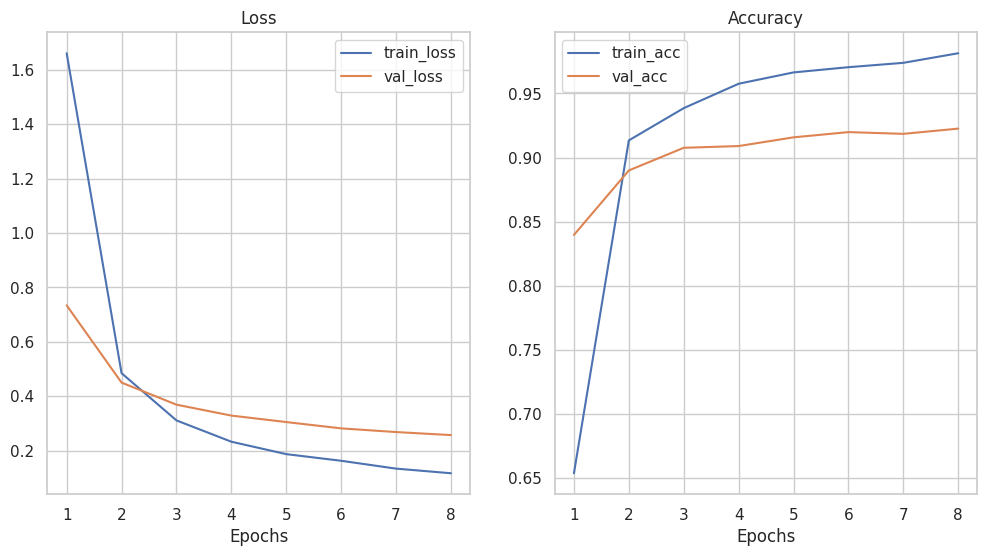

In [14]:
# Load the data
train_data, val_data, test_data = load_data()
batch_size = 32
data_aug = False

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=batch_size,shuffle=False, num_workers=2)

model = create_model(include_layers=1, fine_tune_bn=False)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler = None

results = train_model(model, nn.CrossEntropyLoss(), optimizer, train_dataloader, val_dataloader, epochs=8, device=device, scheduler=scheduler)
# plot results
create_graphs(results, 'graphs2/1layer_basic')

The best result in validation acc was: Accuracy: 90.8%, Avg loss: 0.335923
The best result in validation loss was: Accuracy: 90.1%, Avg loss: 0.303870

## Fine-tuning phase 1: Fine-tuning more layers

Epoch 1
-------------------------------


  0%|          | 0/92 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
loss: 0.076617  Batch:[   91/   92]:  99%|█████████▉| 91/92 [00:21<00:00,  5.51it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
loss: 0.076617  Batch:[   91/   92]: 100%|██████████| 92/92 [00:21<00:00,  4.31it/s]


Validation Error: 
 Accuracy: 92.7%, Avg loss: 0.218550 

Epoch 2
-------------------------------


loss: 0.009475  Batch:[   91/   92]: 100%|██████████| 92/92 [00:21<00:00,  4.30it/s]


Validation Error: 
 Accuracy: 93.2%, Avg loss: 0.223960 

Epoch 3
-------------------------------


loss: 0.002451  Batch:[   91/   92]: 100%|██████████| 92/92 [00:21<00:00,  4.20it/s]


Validation Error: 
 Accuracy: 93.5%, Avg loss: 0.231031 

Epoch 4
-------------------------------


loss: 0.001630  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  4.00it/s]


Validation Error: 
 Accuracy: 93.3%, Avg loss: 0.249349 

Epoch 5
-------------------------------


loss: 0.002840  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.95it/s]


Validation Error: 
 Accuracy: 93.2%, Avg loss: 0.256384 

Epoch 6
-------------------------------


loss: 0.001207  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.94it/s]


Validation Error: 
 Accuracy: 93.1%, Avg loss: 0.266611 

Epoch 7
-------------------------------


loss: 0.000365  Batch:[   91/   92]: 100%|██████████| 92/92 [00:21<00:00,  4.23it/s]


Validation Error: 
 Accuracy: 93.3%, Avg loss: 0.279145 

Epoch 8
-------------------------------


loss: 0.000798  Batch:[   91/   92]: 100%|██████████| 92/92 [00:21<00:00,  4.33it/s]


Validation Error: 
 Accuracy: 93.5%, Avg loss: 0.281569 

Training done!


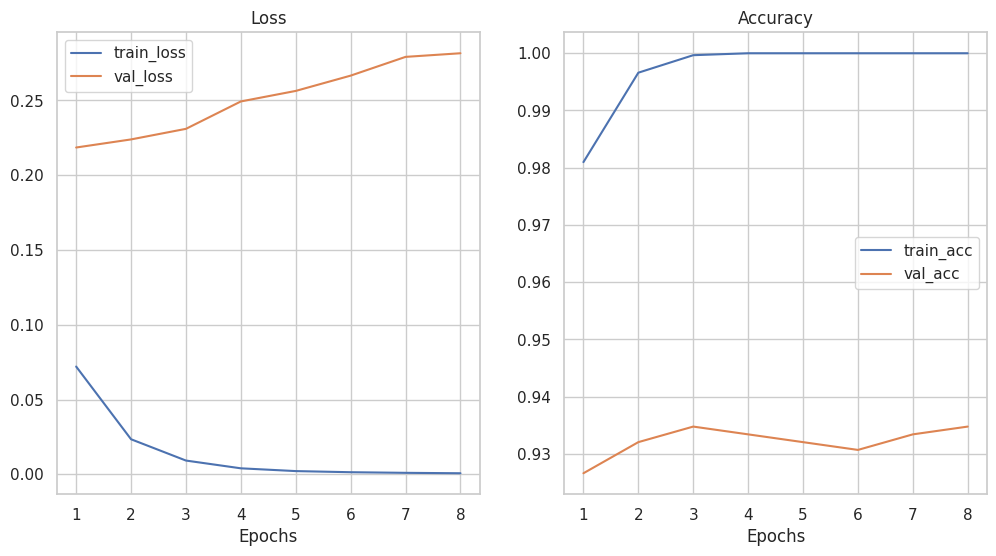

In [15]:
# load in the best model (with regards to val loss)
model.load_state_dict(torch.load('best_model_loss.pth'))
# save the model so it isnt ruined
torch.save(model.state_dict(), 'best_model_loss_1layer.pth')

# lets unfreeze layer4
for param in model.layer4.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = None

results = train_model(model, nn.CrossEntropyLoss(), optimizer, train_dataloader, val_dataloader, epochs=8, device=device, scheduler=scheduler)

create_graphs(results, 'graphs2/1layer_unfreeze_layer4')

#### The best model with 4th layer unfrozen achieved:
Validation Error:
 Accuracy: 93.1%, Avg loss: 0.226672

In [16]:
# save the best model with 4th-layer unfrozen
model.load_state_dict(torch.load('best_model_loss.pth'))
torch.save(model.state_dict(), 'best_model_loss_unfreeze_layer4.pth')

As indicated by the graph, we have now achieved 100% test accuracy. Lets try to train a few epochs using data augmentation

## Phase 2: Data augmentation and unfreezing layers

Epoch 1
-------------------------------


  0%|          | 0/92 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
loss: 1.591744  Batch:[   91/   92]:  99%|█████████▉| 91/92 [00:27<00:00,  3.64it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
loss: 1.591744  Batch:[   91/   92]: 100%|██████████| 92/92 [00:28<00:00,  3.28it/s]


Validation Error: 
 Accuracy: 91.7%, Avg loss: 0.228701 

Epoch 2
-------------------------------


loss: 1.872163  Batch:[   91/   92]: 100%|██████████| 92/92 [00:28<00:00,  3.26it/s]


Validation Error: 
 Accuracy: 91.8%, Avg loss: 0.223481 

Epoch 3
-------------------------------


loss: 0.866816  Batch:[   91/   92]: 100%|██████████| 92/92 [00:26<00:00,  3.46it/s]


Validation Error: 
 Accuracy: 91.7%, Avg loss: 0.227638 

Epoch 4
-------------------------------


loss: 1.138044  Batch:[   91/   92]: 100%|██████████| 92/92 [00:28<00:00,  3.24it/s]


Validation Error: 
 Accuracy: 92.3%, Avg loss: 0.219382 

Epoch 5
-------------------------------


loss: 0.764765  Batch:[   91/   92]: 100%|██████████| 92/92 [00:28<00:00,  3.23it/s]


Validation Error: 
 Accuracy: 91.4%, Avg loss: 0.236004 

Epoch 6
-------------------------------


loss: 0.712262  Batch:[   91/   92]: 100%|██████████| 92/92 [00:28<00:00,  3.23it/s]


Validation Error: 
 Accuracy: 92.1%, Avg loss: 0.224710 

Epoch 7
-------------------------------


loss: 0.935948  Batch:[   91/   92]: 100%|██████████| 92/92 [00:26<00:00,  3.46it/s]


Validation Error: 
 Accuracy: 91.8%, Avg loss: 0.235298 

Epoch 8
-------------------------------


loss: 0.937403  Batch:[   91/   92]: 100%|██████████| 92/92 [00:27<00:00,  3.29it/s]


Validation Error: 
 Accuracy: 92.5%, Avg loss: 0.211819 

Epoch 9
-------------------------------


loss: 0.642350  Batch:[   91/   92]: 100%|██████████| 92/92 [00:27<00:00,  3.30it/s]


Validation Error: 
 Accuracy: 92.8%, Avg loss: 0.208392 

Epoch 10
-------------------------------


loss: 0.689838  Batch:[   91/   92]: 100%|██████████| 92/92 [00:27<00:00,  3.31it/s]


Validation Error: 
 Accuracy: 92.4%, Avg loss: 0.212276 

Epoch 11
-------------------------------


loss: 1.028746  Batch:[   91/   92]: 100%|██████████| 92/92 [00:26<00:00,  3.44it/s]


Validation Error: 
 Accuracy: 91.4%, Avg loss: 0.223957 

Epoch 12
-------------------------------


loss: 0.676393  Batch:[   91/   92]: 100%|██████████| 92/92 [00:28<00:00,  3.28it/s]


Validation Error: 
 Accuracy: 92.0%, Avg loss: 0.218259 

Epoch 13
-------------------------------


loss: 0.579234  Batch:[   91/   92]: 100%|██████████| 92/92 [00:28<00:00,  3.18it/s]


Validation Error: 
 Accuracy: 93.1%, Avg loss: 0.199986 

Epoch 14
-------------------------------


loss: 0.880449  Batch:[   91/   92]: 100%|██████████| 92/92 [00:27<00:00,  3.36it/s]


Validation Error: 
 Accuracy: 92.5%, Avg loss: 0.211739 

Epoch 15
-------------------------------


loss: 0.742757  Batch:[   91/   92]: 100%|██████████| 92/92 [00:28<00:00,  3.23it/s]


Validation Error: 
 Accuracy: 92.1%, Avg loss: 0.226976 

Training done!


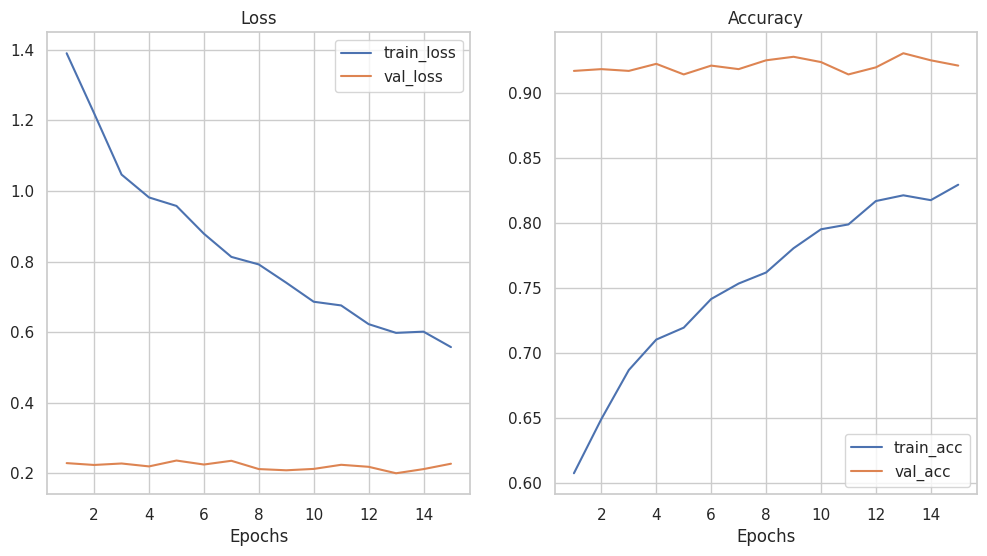

In [17]:
# load in the best model (with regards to val loss)
# create the model
model = create_model(include_layers=1, fine_tune_bn=False)

model.load_state_dict(torch.load('best_model_loss_unfreeze_layer4.pth'))
#model.load_state_dict(torch.load('best_model_loss.pth'))
# lets define the optimizers
batch_size = 32
scheduler = None

# freeze all layers
for param in model.parameters():
    param.requires_grad = False
# unfreeze
for param in model.layer4.parameters():
    param.requires_grad = True

for param in model.fc.parameters():
     param.requires_grad = True

optimizer = torch.optim.Adam([
        {'params': model.layer4.parameters(), 'lr': 1e-5},
        {'params': model.fc.parameters(), 'lr': 1e-4}
        ], weight_decay=1e-4)

# load the data
train_data, val_data, test_data = load_data(transform=train_transform)
# dataloaders
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=batch_size,shuffle=False, num_workers=2)


# train the model
results = train_model(model, nn.CrossEntropyLoss(), optimizer, train_dataloader, val_dataloader,
                      epochs=15, device=device, scheduler=scheduler, data_aug=False)

create_graphs(results, 'graphs2/4layer_data_aug')

With data-augmentation the results dipped but we can see that the training allows for further improvement.
The best results with data aug was Validation Error:
 Accuracy: 78.1%, Avg loss: 0.675053.

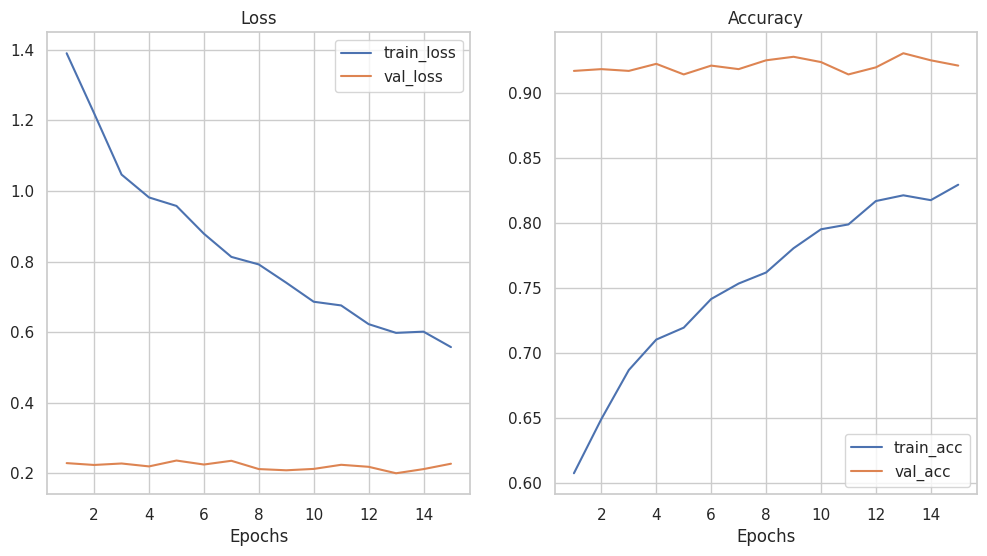

In [18]:
# load the current best
model.load_state_dict(torch.load('best_model_loss.pth'))
# save the model
torch.save(model.state_dict(), 'best_model_loss_unfreeze_layer4_data_aug.pth')
create_graphs(results, 'graphs2/4layer_data_aug')

### Lets try unfreezing an additional layer and train with data aug

Epoch 1
-------------------------------


  0%|          | 0/92 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
loss: 0.483437  Batch:[   91/   92]: 100%|██████████| 92/92 [00:30<00:00,  4.65it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
loss: 0.483437  Batch:[   91/   92]: 100%|██████████| 92/92 [00:30<00:00,  3.06it/s]


Validation Error: 
 Accuracy: 91.2%, Avg loss: 0.221149 

Epoch 2
-------------------------------


loss: 0.316898  Batch:[   91/   92]: 100%|██████████| 92/92 [00:29<00:00,  3.15it/s]


Validation Error: 
 Accuracy: 91.2%, Avg loss: 0.223921 

Epoch 3
-------------------------------


loss: 0.270888  Batch:[   91/   92]: 100%|██████████| 92/92 [00:29<00:00,  3.10it/s]


Validation Error: 
 Accuracy: 93.8%, Avg loss: 0.201456 

Epoch 4
-------------------------------


loss: 0.226312  Batch:[   91/   92]: 100%|██████████| 92/92 [00:29<00:00,  3.07it/s]


Validation Error: 
 Accuracy: 92.3%, Avg loss: 0.214035 

Epoch 5
-------------------------------


loss: 0.621680  Batch:[   91/   92]: 100%|██████████| 92/92 [00:29<00:00,  3.07it/s]


Validation Error: 
 Accuracy: 92.3%, Avg loss: 0.222663 

Epoch 6
-------------------------------


loss: 0.649257  Batch:[   91/   92]: 100%|██████████| 92/92 [00:29<00:00,  3.15it/s]


Validation Error: 
 Accuracy: 92.3%, Avg loss: 0.213661 

Epoch 7
-------------------------------


loss: 0.428698  Batch:[   91/   92]: 100%|██████████| 92/92 [00:29<00:00,  3.11it/s]


Validation Error: 
 Accuracy: 91.6%, Avg loss: 0.230573 

Epoch 8
-------------------------------


loss: 0.533055  Batch:[   91/   92]: 100%|██████████| 92/92 [00:29<00:00,  3.07it/s]


Validation Error: 
 Accuracy: 92.5%, Avg loss: 0.231595 

Early stopping!
Training done!


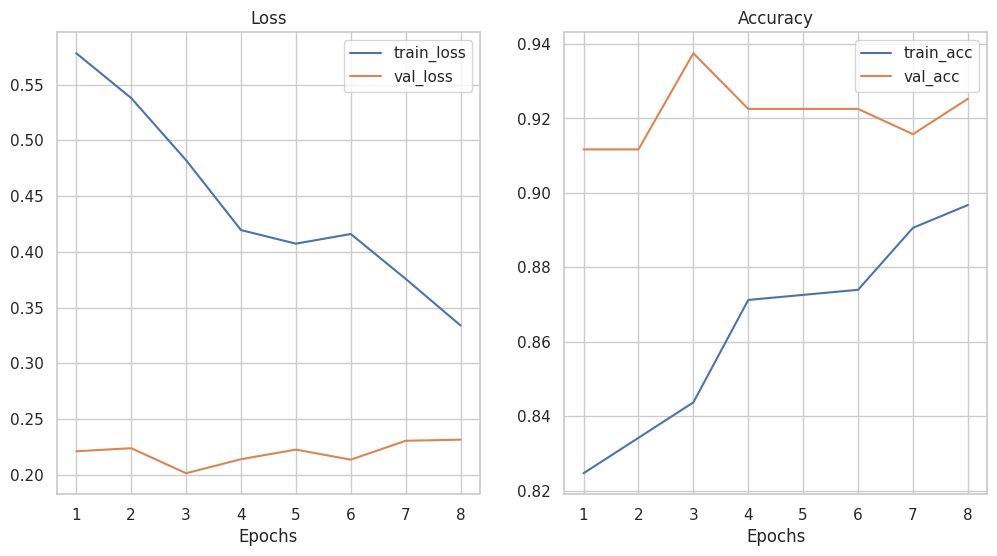

In [19]:
# load in the best model (with regards to val loss)
model.load_state_dict(torch.load('best_model_loss_unfreeze_layer4_data_aug.pth'))
#model.load_state_dict(torch.load('best_model_loss.pth'))
# lets define the optimizers

scheduler = None

# freeze all layers
for param in model.parameters():
    param.requires_grad = False
# unfreeze
for param in model.layer3.parameters():
    param.requires_grad = True

for param in model.layer4.parameters():
    param.requires_grad = True

for param in model.fc.parameters():
     param.requires_grad = True

optimizer = torch.optim.Adam([
        {'params': model.layer3.parameters(), 'lr': 1e-5},
        {'params': model.layer4.parameters(), 'lr': 1e-5},
        {'params': model.fc.parameters(), 'lr': 1e-4}
        ], weight_decay=1e-4)
# load the data
train_data, val_data, test_data = load_data(transform=train_transform)
# dataloaders
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=batch_size,shuffle=False, num_workers=2)


# train the model
results = train_model(model, nn.CrossEntropyLoss(), optimizer, train_dataloader, val_dataloader,
                      epochs=15, device=device, scheduler=scheduler, data_aug=False)

create_graphs(results, 'graphs2/3layer_data_aug')

Okay so it improved pretty well. Best result: Validation Error:
 Accuracy: 91.4%, Avg loss: 0.252865

In [20]:
# load best validation loss
model.load_state_dict(torch.load('best_model_loss.pth'))
# save best
torch.save(model.state_dict(), 'best_model_loss_unfreeze_layer3_data_aug.pth')

Lets try just training the top layers without data aug and see if that works

Epoch 1
-------------------------------


loss: 0.005536  Batch:[   91/   92]: 100%|██████████| 92/92 [00:21<00:00,  4.31it/s]


Validation Error: 
 Accuracy: 92.9%, Avg loss: 0.221857 

Epoch 2
-------------------------------


loss: 0.005349  Batch:[   91/   92]: 100%|██████████| 92/92 [00:21<00:00,  4.38it/s]


Validation Error: 
 Accuracy: 92.8%, Avg loss: 0.204915 

Epoch 3
-------------------------------


loss: 0.008108  Batch:[   91/   92]: 100%|██████████| 92/92 [00:20<00:00,  4.39it/s]


Validation Error: 
 Accuracy: 93.8%, Avg loss: 0.220441 

Epoch 4
-------------------------------


loss: 0.000814  Batch:[   91/   92]: 100%|██████████| 92/92 [00:20<00:00,  4.45it/s]


Validation Error: 
 Accuracy: 93.6%, Avg loss: 0.222205 

Epoch 5
-------------------------------


loss: 0.000725  Batch:[   91/   92]: 100%|██████████| 92/92 [00:22<00:00,  4.11it/s]


Validation Error: 
 Accuracy: 93.6%, Avg loss: 0.230630 

Training done!


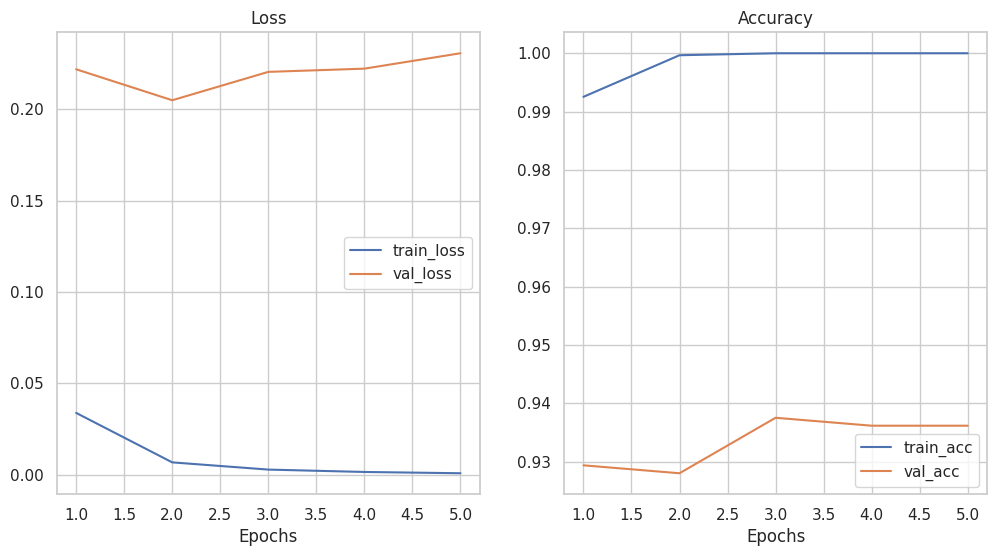

In [25]:
# load in the best model (with regards to val loss)
model.load_state_dict(torch.load('best_model_loss_unfreeze_layer4_data_aug.pth'))
#model.load_state_dict(torch.load('best_model_loss.pth'))
# lets define the optimizers

scheduler = None

# freeze all layers
for param in model.parameters():
    param.requires_grad = False
# unfreeze
for param in model.layer4.parameters():
    param.requires_grad = True

for param in model.fc.parameters():
     param.requires_grad = True

optimizer = torch.optim.Adam([
        {'params': model.layer4.parameters(), 'lr': 1e-5},
        {'params': model.fc.parameters(), 'lr': 1e-4}
        ], weight_decay=1e-4)

# load the data
train_data, val_data, test_data = load_data(transform=None)
# dataloaders
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=batch_size,shuffle=False, num_workers=2)


# train the model
results = train_model(model, nn.CrossEntropyLoss(), optimizer, train_dataloader, val_dataloader,
                      epochs=5, device=device, scheduler=scheduler, data_aug=False)

create_graphs(results, 'graphs2/temp2')

In [22]:
# load best
model.load_state_dict(torch.load('best_model_loss.pth'))
# save as temp
torch.save(model.state_dict(), 'phase2')

## Phase 3: Experimentation with batch_norm and learning rate schedulers

In [24]:
# lets evaluate model
model.load_state_dict(torch.load('best_model_loss_unfreeze_layer4_data_aug.pth'))

# load in data from original dataset
train_data = OxfordIIITPet(root='dataset', split='trainval', target_types='category', transform=resnet_preprocess, download=True)
test_data = OxfordIIITPet(root='dataset', split='test', target_types='category', transform=resnet_preprocess, download=True)

# dataloaders
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=batch_size,shuffle=False, num_workers=2)

# freeze all layers
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

for param in model.layer4.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam([
        {'params': model.layer4.parameters(), 'lr': 1e-5},
        {'params': model.fc.parameters(), 'lr': 1e-4}
        ], weight_decay=1e-4)

scheduler = None

# train for one epoch
results = train_model(model, nn.CrossEntropyLoss(), optimizer, train_dataloader, train_dataloader,
                      epochs=1, device=device, scheduler=scheduler, data_aug=False)


accuracy, test_loss = evaluate_model(test_dataloader, model, nn.CrossEntropyLoss(), device)

print(f"Test Accuracy: {accuracy:.2f}%")

Epoch 1
-------------------------------


loss: 0.142746  Batch:[  111/  115]: 100%|██████████| 115/115 [00:28<00:00,  4.09it/s]


Validation Error: 
 Accuracy: 99.6%, Avg loss: 0.024396 

Training done!
Test Accuracy: 91.06%


In [26]:

test_loss

0.2772512126964537